# CytoData 2023 Hackathon

This is an example Notebook that presents how the hackathon data can be used.

In [1]:
# Import used libraries
import os
import re
import random
import imageio
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import sklearn.preprocessing
import sklearn.ensemble
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import umap
import umap.plot
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from PIL import Image, ImageFilter

2023-10-25 20:07:38.105146: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# Define needed paths
root_path = Path('/').joinpath(*Path(os.getcwd()).parts[1:3])
img_path = root_path / 'images'
meta_path = root_path / 'metadata'
trainfeat_path = meta_path / 'cytodata2023_hackathon_features_train.csv'
testfeat_path = meta_path / 'cytodata2023_hackathon_features_test.csv'
trainmeta_path = meta_path / 'cytodata2023_hackathon_train.csv'
testmeta_path = meta_path / 'cytodata2023_hackathon_test.csv'
channels = ['1_AF488', '1_AF555', '1_AF647', '1_AF750', '1_DAPI', '2_AF647']

cell_centers = meta_path / 'cytodata2023_hackathon_features_withloc_test.csv'

## Helper functions

In [3]:
def crop_rgb_tiles(img, cshape, rand_boxes=0):
    boxes = []
    if rand_boxes > 0:
        for i in range(rand_boxes):
            boxes.append((np.random.randint(0,img.shape[0]-cshape[0]), np.random.randint(0,img.shape[1]-cshape[1])))
    else:
        boxes = [(y,x) for x in range((img.shape[1]%cshape[1])//2, img.shape[1]-cshape[1], cshape[1])
                 for y in range((img.shape[0]%cshape[0])//2, img.shape[0]-cshape[0], cshape[0])]
    
    tiles = np.zeros((len(boxes),cshape[0],cshape[1],3), dtype=np.float32)
    for i,(sx,sy) in enumerate(boxes):
        cimg = img[sy:sy+cshape[0], sx:sx+cshape[1]]
        tiles[i,:,:,0] = cimg
        tiles[i,:,:,1] = cimg
        tiles[i,:,:,2] = cimg
    
    return tiles

In [14]:
df_metadata_train = pd.read_csv(trainmeta_path)
idx = df_metadata_train.sample(n=1).index[0]
imgpaths = img_path.glob(df_metadata_train.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata_train.loc[idx,'ROI number']))
imgpaths = [x for x in imgpaths]
imgpaths.sort()

seg_dir = '/scratch/project_2008672/matolonen/CytoData2023Hackathon/cytodata-hackathon-2023/images/stardist_seg_results_downsized/'
segmentations = '/scratch/project_2008672/niemeyfr/CytoData2023Hackathon/cytodata-hackathon-2023/images/'
segpaths = os.listdir(seg_dir)
segpaths.sort()

# for seg_img_filename in segpaths:

#     seg_img = Image.open(seg_dir + seg_img_filename)
#     # Calculate the new dimensions by doubling both width and height
#     width, height = seg_img.size
#     upscaled_width = width * 2
#     upscaled_height = height * 2

#     # Resize the image to the new dimensions using nearest-neighbor interpolation
#     upscaled_image = seg_img.resize((upscaled_width, upscaled_height), Image.NEAREST)
#     upscaled_image.save(segmentations + seg_img_filename.split('.')[0] + '.png')

In [15]:
# Check channel distributions for preprocessing using 20% of images (NOTE: mixes train and test images)
ch_dist = {}
for ch in channels:
    files = [x for x in img_path.glob(f'*{ch}*')]
    files = random.choices(files, k=int(len(files)*0.2))
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))
#     ch_dist[ch] = (1,1)

0it [00:00, ?it/s]/run/nvme/job_19122168/tmp/ipykernel_2300776/2125587616.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(fpath)
76it [00:36,  2.10it/s]
76it [00:32,  2.35it/s]
76it [00:35,  2.16it/s]
76it [00:34,  2.20it/s]
76it [00:36,  2.10it/s]
76it [00:45,  1.68it/s]


In [20]:
from scipy.signal import convolve2d
from scipy.ndimage import binary_dilation

crop_size = 4240
input_shape = (256,256,3)
num_boxes = 64

segmentations = Path('/').joinpath(segmentations)

# Initialize an empty list to store the feature data
df_features = pd.DataFrame()

subset = df_metadata_train.head(10)

# Iterate through image paths
for idx, row in tqdm(subset.iterrows()):
    ipaths = img_path.glob(row['Slide'] + '*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'], row['ROI number']))
    
    # Get nuclei segmentation mask
    seg_paths = segmentations.glob(row['Slide'] + '*roi{:03d}*'.format(row['ROI number']))
    for path in seg_paths:
        mask = imageio.imread(path).astype(np.float32)
    
    # Perform dilation to cover whole cell
    dilation_factor = 5
    structure_element = np.ones((dilation_factor, dilation_factor), dtype=np.uint8)
    mask = binary_dilation(mask, structure=structure_element)
    
    # Initialize a list to store features for this ROI
    features = []
    
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        img = img[:crop_size,:crop_size]

        convolved_image = np.zeros_like(img)
        convolved_image[mask == 1] = img[mask == 1]
        
        # Crop the image into tiles
        tiles = crop_rgb_tiles(img, input_shape, rand_boxes=num_boxes)
        
        # Initialize an array to store features for this image
        feat = np.zeros((tiles.shape[0],), dtype=np.float32)
        
        # Get mean image intensity values from each tile
        for i in range(tiles.shape[0]):
            feat[i] = tiles[i, :, :, :].mean()
        features.append(feat)
    
    # Combine the features for this ROI into a single array
    combined_features = np.concatenate(features, axis=0)
    
    # DataFrame for this ROI's features
    df_features["{}_toi{}".format(row['Slide'], row['ROI number'])] = combined_features

df_features

0it [00:00, ?it/s]/run/nvme/job_19122168/tmp/ipykernel_2300776/2359389402.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(path).astype(np.float32)
/run/nvme/job_19122168/tmp/ipykernel_2300776/2359389402.py:35: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)
1it [00:03,  3.68s/it]/run/nvme/job_19122168/tmp/ipykernel_2300776/2359389402.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear)

,TMA-06_toi29,TMA-09_toi66,TMA-07_toi67,TMA-03_toi52,TMA-06_toi27,TMA-02_toi52,TMA-09_toi29,TMA-04_toi73,TMA-08_toi51,TMA-07_toi97
0,-0.265226,0.172922,-0.202971,0.153362,0.857525,0.961427,-0.435597,-0.171412,-0.251250,0.168872
1,0.425671,0.167045,0.388760,0.272133,-0.265061,0.318266,0.261408,-0.007540,-0.222952,0.434913
2,-0.266345,-0.023602,-0.000142,0.233411,-0.264133,-0.251869,-0.230465,-0.154889,-0.244254,-0.337102
3,-0.267689,-0.099204,-0.208945,-0.267855,-0.267567,0.226629,0.696348,-0.392690,-0.256835,-0.343546
4,-0.272835,-0.069543,0.052838,0.254507,-0.237762,0.060048,0.185746,-0.400902,-0.250621,0.337091
...,...,...,...,...,...,...,...,...,...,...
379,1.170742,-0.387514,-0.252133,-0.360296,-0.244484,-0.436233,-0.120896,-0.483771,-0.385902,-0.268817
380,-0.500860,-0.407283,-0.207331,-0.361134,-0.539162,-0.459575,-0.201197,0.271216,-0.235914,-0.275607
381,-0.505979,-0.159979,1.109906,-0.246194,-0.496002,-0.438797,-0.023387,0.327672,-0.403020,-0.263439
382,-0.493277,-0.310105,-0.247797,-0.309685,-0.106576,0.218952,-0.196713,-0.127096,-0.033628,-0.264109


['TMA-01_1_DAPI_roi146_stardist_2D_versatile_fluo.tif',
 'TMA-04_1_DAPI_roi017_stardist_2D_versatile_fluo.tif',
 'TMA-02_1_DAPI_roi107_stardist_2D_versatile_fluo.tif',
 'TMA-02_1_DAPI_roi032_stardist_2D_versatile_fluo.tif',
 'TMA-02_1_DAPI_roi143_stardist_2D_versatile_fluo.tif',
 'TMA-05_1_DAPI_roi079_stardist_2D_versatile_fluo.tif',
 'TMA-05_1_DAPI_roi109_stardist_2D_versatile_fluo.tif',
 'TMA-07_1_DAPI_roi105_stardist_2D_versatile_fluo.tif',
 'TMA-04_1_DAPI_roi130_stardist_2D_versatile_fluo.tif',
 'TMA-05_1_DAPI_roi088_stardist_2D_versatile_fluo.tif',
 'TMA-09_1_DAPI_roi023_stardist_2D_versatile_fluo.tif',
 'TMA-02_1_DAPI_roi124_stardist_2D_versatile_fluo.tif',
 'TMA-06_1_DAPI_roi087_stardist_2D_versatile_fluo.tif',
 'TMA-06_1_DAPI_roi013_stardist_2D_versatile_fluo.tif',
 'TMA-05_1_DAPI_roi085_stardist_2D_versatile_fluo.tif',
 'TMA-08_1_DAPI_roi049_stardist_2D_versatile_fluo.tif',
 'TMA-07_1_DAPI_roi068_stardist_2D_versatile_fluo.tif',
 'TMA-01_1_DAPI_roi034_stardist_2D_versatile_flu

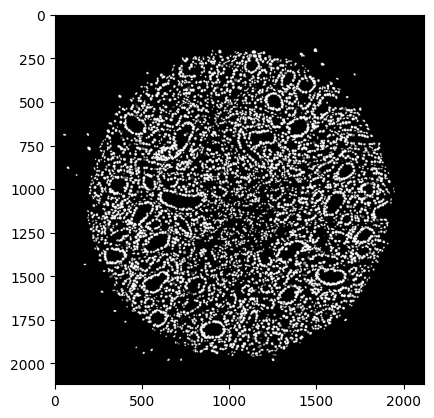

In [8]:
segment = Image.open('/scratch/project_2008672/matolonen/CytoData2023Hackathon/cytodata-hackathon-2023/images/stardist_seg_results_downsized/TMA-01_1_DAPI_roi146_stardist_2D_versatile_fluo.tif')
plt.imshow(segment)

## Read and check metadata and features

In [4]:
df_metadata_train = pd.read_csv(trainmeta_path)
df_features_train = pd.read_csv(trainfeat_path)

In [5]:
# Check metadata
df_metadata_train

,Slide,ROI number,PatientID,Location,Annotation Color,Progression,pT,Fuhrman
0,TMA-06,29,1,3,Blue2,1,3,2
1,TMA-09,66,2,2,Red1,1,2,3
2,TMA-07,67,4,3,Blue1,1,3,3
3,TMA-03,52,8,3,Blue2,0,3,2
4,TMA-06,27,1,2,Red2,1,3,2
...,...,...,...,...,...,...,...,...
237,TMA-04,127,68,2,Red1,0,1,1
238,TMA-01,11,58,2,Red1,0,1,2
239,TMA-03,124,34,3,Blue2,0,1,2
240,TMA-07,107,23,3,Blue1,1,1,2


In [6]:
# Check features
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_MedianIntensity_Fap,Intensity_MedianIntensity_Pdgfra,Intensity_MedianIntensity_Pdgfrb,Intensity_MedianIntensity_Sma,Intensity_UpperQuartileIntensity_Dapi,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.010697,0.004280,0.010742,0.004524,0.023926,0.073678,0.014145,0.004990,0.013458,0.005539
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.007980,0.003830,0.007645,0.003494,0.127466,0.042306,0.009567,0.004273,0.008797,0.003876
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.008995,0.004883,0.009651,0.003799,0.067735,0.055001,0.013588,0.005570,0.011788,0.004410
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.009384,0.004288,0.068093,0.007568,0.123033,0.051465,0.013287,0.004776,0.099508,0.013188
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.037697,0.005173,0.015709,0.005997,0.103346,0.027802,0.053239,0.006271,0.032040,0.010449
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.006096,0.003174,0.004852,0.002823,0.057225,0.021050,0.007000,0.003857,0.005947,0.003220
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.009071,0.003754,0.006859,0.003494,0.041238,0.023980,0.011872,0.004395,0.008614,0.004223
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.008042,0.002655,0.004730,0.002777,0.017174,0.027977,0.011040,0.003418,0.007980,0.003799
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.011765,0.005142,0.011429,0.005165,0.083185,0.087358,0.015732,0.006256,0.016266,0.006222
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.008728,0.004402,0.009422,0.003906,0.052129,0.071202,0.010986,0.005005,0.011402,0.004410


In [7]:
# Merge features and metadata, drop 'Annotation Color' columns
df_features_train = df_features_train.merge(df_metadata_train, on=['Slide','ROI number'], how='left')
df_features_train = df_features_train.drop('Annotation Color', axis=1)
df_features_train.head(n=10)

,Slide,ROI number,ObjectNumber,Intensity_MaxIntensity_Dapi,Intensity_MaxIntensity_Epi,Intensity_MaxIntensity_Fap,Intensity_MaxIntensity_Pdgfra,Intensity_MaxIntensity_Pdgfrb,Intensity_MaxIntensity_Sma,Intensity_MeanIntensity_Dapi,...,Intensity_UpperQuartileIntensity_Epi,Intensity_UpperQuartileIntensity_Fap,Intensity_UpperQuartileIntensity_Pdgfra,Intensity_UpperQuartileIntensity_Pdgfrb,Intensity_UpperQuartileIntensity_Sma,PatientID,Location,Progression,pT,Fuhrman
0,TMA-01,11,1,0.032380,0.121126,0.021683,0.006744,0.025864,0.028534,0.020687,...,0.073678,0.014145,0.004990,0.013458,0.005539,58,2,0,1,2
1,TMA-01,11,2,0.199237,0.850782,0.017700,0.006470,0.016800,0.007324,0.096314,...,0.042306,0.009567,0.004273,0.008797,0.003876,58,2,0,1,2
2,TMA-01,11,3,0.099306,0.106569,0.027909,0.007019,0.015640,0.005707,0.049421,...,0.055001,0.013588,0.005570,0.011788,0.004410,58,2,0,1,2
3,TMA-01,11,4,0.200458,0.146044,0.033417,0.008286,0.175113,0.119448,0.096978,...,0.051465,0.013287,0.004776,0.099508,0.013188,58,2,0,1,2
4,TMA-01,11,5,0.166690,0.054231,0.105028,0.013413,0.226246,0.121859,0.080197,...,0.027802,0.053239,0.006271,0.032040,0.010449,58,2,0,1,2
5,TMA-01,11,6,0.085069,0.066743,0.011948,0.007050,0.008927,0.004807,0.042293,...,0.021050,0.007000,0.003857,0.005947,0.003220,58,2,0,1,2
6,TMA-01,11,7,0.064485,0.081666,0.028000,0.006409,0.012146,0.006577,0.032515,...,0.023980,0.011872,0.004395,0.008614,0.004223,58,2,0,1,2
7,TMA-01,11,8,0.034745,0.088228,0.024720,0.005447,0.064530,0.017243,0.014551,...,0.027977,0.011040,0.003418,0.007980,0.003799,58,2,0,1,2
8,TMA-01,11,9,0.136751,0.119799,0.035615,0.009018,0.023606,0.007630,0.070673,...,0.087358,0.015732,0.006256,0.016266,0.006222,58,2,0,1,2
9,TMA-01,11,10,0.066804,0.143328,0.021271,0.006714,0.016449,0.005966,0.045375,...,0.071202,0.010986,0.005005,0.011402,0.004410,58,2,0,1,2


## Visualize images

Open a random core and visualize it.

In [8]:
idx = df_metadata_train.sample(n=1).index[0]
imgpaths = img_path.glob(df_metadata_train.loc[idx,'Slide']+'*roi{:03d}*'.format(df_metadata_train.loc[idx,'ROI number']))
imgpaths = [x for x in imgpaths]
imgpaths.sort()

/run/nvme/job_19113041/tmp/ipykernel_2196564/865043981.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ipath).astype(np.float32)


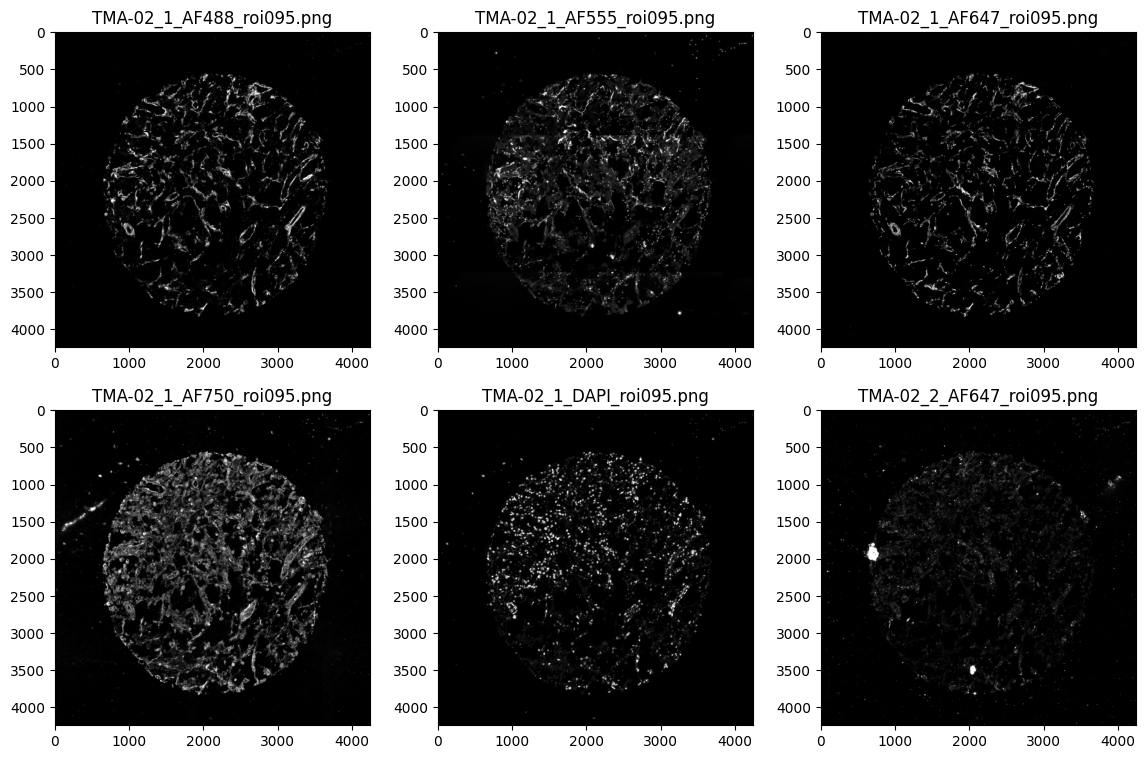

In [9]:
# There should be 6 images to view
rows = 2
cols = 3
fig,ax = plt.subplots(rows,cols,figsize=(14,9))
for i,ipath in enumerate(imgpaths):
    img = imageio.imread(ipath).astype(np.float32)
    # Scale images from median (bg) to 0.998 quantile for visualization
    intlow,inthigh = np.quantile(img,[0.5,0.998])
    img = (img - intlow) / (inthigh-intlow)
    img[img<0.0] = 0.0
    img[img>1.0] = 1.0
    img = (img * 255.0).astype(np.uint8)
    ax[i//cols, i%cols].imshow(img, cmap='gray')
    ax[i//cols, i%cols].set_title(ipath.name)

## Classical features

### Preprocess features

In [34]:
# Feature columns
featcols = [x for x in df_features_train.columns if 'Intensity' in x]

NameError: name 'df_features_train' is not defined

In [35]:
# drop NA
prep_features = df_features_train.dropna()

NameError: name 'df_features_train' is not defined

In [12]:
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(prep_features[featcols])
prep_features.loc[:,featcols] = scaler.transform(prep_features[featcols])
prep_features = prep_features.dropna()

In [13]:
# Visualize 10% of the single-cell features of training data
mapper = umap.UMAP()
umap_sample = prep_features[featcols].sample(frac=0.1)
mapper.fit(umap_sample)

UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

<Axes: >

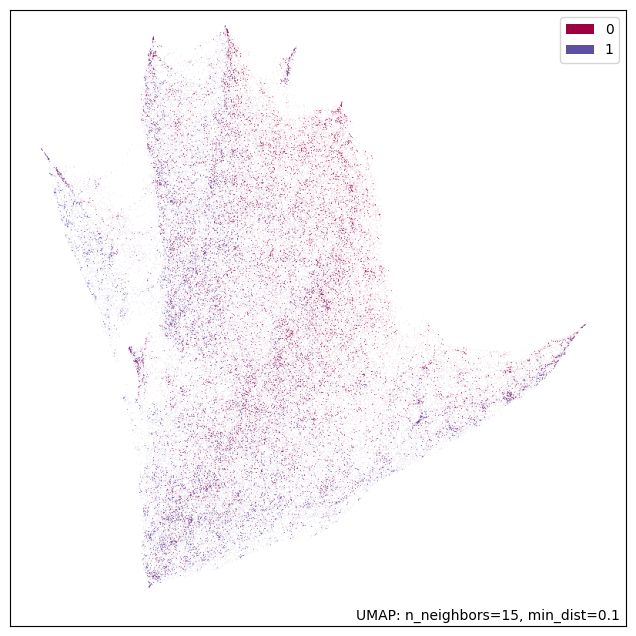

In [14]:
umap.plot.points(mapper, labels=prep_features.loc[umap_sample.index,'Progression'])

### Toy classification example

In [32]:
# Median features for each ROI
med_features = prep_features.groupby(['Slide','ROI number']).median().reset_index()

NameError: name 'prep_features' is not defined

In [33]:
# Use single-cell features for classification
# Sample 30% to validation
X_train = med_features[featcols].sample(frac=0.7)
y_train = med_features.loc[X_train.index,'Progression']
X_test = med_features.loc[~med_features.index.isin(X_train.index),featcols]
y_test = med_features.loc[X_test.index,'Progression']

NameError: name 'med_features' is not defined

In [17]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [18]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [19]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

Accuracy: 0.781
Precision: 0.750
Recall: 0.750


## DL features with pretrained network

In [20]:
input_shape = (256,256,3)
dl_featcols = ['feat_{}'.format(x) for x in range(2048)]

In [1]:
# Check channel distributions for preprocessing using 20% of images (NOTE: mixes train and test images)
ch_dist = {}
for ch in channels:
    files = [x for x in img_path.glob(f'*{ch}*')]
    files = random.choices(files, k=int(len(files)*0.2))
    dist = np.zeros((len(files),2), dtype=np.float32)
    for i,fpath in tqdm(enumerate(files)):
        img = imageio.imread(fpath)
        dist[i,0] = img.mean()
        dist[i,1] = img.std()
    ch_dist[ch] = (np.mean(dist[:,0]), np.mean(dist[:,1]))

NameError: name 'channels' is not defined

In [ ]:
ch_dist

In [ ]:
# Load pretrained model
resnet = tf.keras.applications.ResNet50(include_top=False, input_shape=input_shape, weights='imagenet', pooling='max')
resnet.summary()

In [ ]:
# Extract features separately for each image, sample 64 boxes per image, not optimized as uses GPU only for the prediction
num_boxes = 64
df_dlrois = []
for idx,row in tqdm(df_metadata_train.iterrows()):
    ipaths = img_path.glob(row['Slide']+'*roi{:03d}*'.format(row['ROI number']))
    pat = re.compile('{}_(\d_\w+)_roi{:03d}.png'.format(row['Slide'],row['ROI number']))
    df_dlchs = []
    for ipath in ipaths:
        ch = pat.match(ipath.name).group(1)
        img = imageio.imread(ipath).astype(np.float32)
        img = (img - ch_dist[ch][0]) / ch_dist[ch][1]
        tiles = crop_rgb_tiles(img, input_shape, rand_boxes=num_boxes)
        feat = np.zeros((tiles.shape[0],2048), dtype=np.float32)
        feat = resnet.predict(tiles)
        df_dlroi = pd.DataFrame(columns=[ch+'_'+x for x in dl_featcols], data=feat)
        df_dlchs.append(df_dlroi)
    df_dlch = pd.concat(df_dlchs, axis=1)
    df_dlch['Slide'] = row['Slide']
    df_dlch['ROI number'] = row['ROI number']
    df_dlrois.append(df_dlch)
df_dlfeat = pd.concat(df_dlrois)

### Preprocess and visualize

In [ ]:
dl_featcols = [x for x in df_dlfeat.columns if 'feat' in x]
df_dlfeat

In [ ]:
dlfeat = df_dlfeat.copy()
dlfeat = dlfeat.merge(df_metadata_train, on=['Slide','ROI number'], how='left').drop('Annotation Color', axis=1)
# Scale features
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(dlfeat[dl_featcols])
dlfeat.loc[:,dl_featcols] = scaler.transform(dlfeat[dl_featcols])
dlfeat = dlfeat.dropna()

In [ ]:
train_feat = dlfeat.sample(frac=0.7)
test_feat = dlfeat.loc[~dlfeat.index.isin(train_feat.index),:]

In [ ]:
# Visualize single-cell features of the training data
umap_sample = train_feat.sample(frac=0.1)
mapper = umap.UMAP()
mapper.fit(umap_sample[dl_featcols])

In [ ]:
umap.plot.points(mapper, labels=umap_sample['Progression'])

### Toy classification with DL features

In [ ]:
train_feat

In [ ]:
med_train_feat = train_feat.groupby(["Slide","ROI number"]).median().reset_index()
med_test_feat = test_feat.groupby(["Slide","ROI number"]).median().reset_index()

In [ ]:
# Use single-cell features for classification
X_train = med_train_feat[dl_featcols]
y_train = med_train_feat['Progression']
X_test = med_test_feat[dl_featcols]
y_test = med_test_feat['Progression']

In [ ]:
# Fit and predict
model = sklearn.ensemble.RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Evaluate
accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
precision = sklearn.metrics.precision_score(y_test, y_pred)
recall = sklearn.metrics.recall_score(y_test, y_pred)

In [ ]:
print("Accuracy: {:.3f}".format(accuracy))
print("Precision: {:.3f}".format(precision))
print("Recall: {:.3f}".format(recall))

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)